In [1]:
import os
import time
from datetime import datetime

import IPython
import IPython.display

import numpy as np
from math import *

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import random 

2022-11-21 09:36:38.038786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-11-21 09:36:38.038823: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Tensorflow

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

2022-11-21 09:36:41.745888: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-11-21 09:36:41.745955: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-21 09:36:41.745996: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hydra
2022-11-21 09:36:41.746010: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hydra
2022-11-21 09:36:41.746133: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-11-21 09:36:41.746196: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.56.6


True

# Case 

In [3]:
folders = ['Rough','UTS','Elon']
index = 1
CASE = folders[index]

In [4]:
from prepross import importAndProcess
xtrain,xval,xtest,ytrain,yval,ytest = importAndProcess(index)
x = pd.concat((xtrain,xtest,xval),axis=0)
y = pd.concat((ytrain,ytest,yval),axis=0)

# Network

In [5]:
# Hyperparameters
lossfn = [tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanAbsolutePercentageError(),tf.keras.losses.MeanAbsoluteError()]
lossfn = lossfn[1]
optimizer = [tf.keras.optimizers.Adam(learning_rate=i,beta_1=0.09,beta_2=0.9) for i in [5e-2,1e-2,5e-3]]
optimizer = optimizer[index]
metrics = ['mean_squared_error','mean_absolute_error',tf.keras.losses.MeanAbsolutePercentageError()]

In [6]:
modelArchitecture = [[7,'tanh',1],[2,'relu',1],[1,'linear',1]]

In [7]:
#Give a random seed
tf.random.set_seed(random.randint(1,1000))
from networks import create_model

In [8]:
# Create a basic model Architecture
modelName = ''
for u,fn,b in modelArchitecture:
    modelName += str(u)+fn+str(b)+'_'
# Create Model
model = create_model(modelArchitecture,modelName,len(xtrain.columns))
# Display the model's architecture
model.summary()
model.compile(optimizer=optimizer,
                loss=lossfn, #tf.keras.losses.MSE
                metrics=metrics) #tf.keras.losses.Huber()


Model: "7tanh1_2relu1_1linear1_"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 63        
                                                                 
 dense_1 (Dense)             (None, 2)                 16        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


2022-11-21 09:36:43.062018: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=100,
                                                    mode='min')
callbacks = [early_stopping]

history = model.fit(xtrain,ytrain,verbose=2,epochs=3500,
                    validation_data=(xval,yval),
                    batch_size = 3,
                    callbacks=callbacks)  # ,tensorboard,checkpoint]))

val_performance = model.evaluate(xval,yval)
performance = model.evaluate(xtest,ytest, verbose=0)
# print(val_performance[modelName])
# print(performance[modelName])

Epoch 1/3500
12/12 - 1s - loss: 95.5946 - mean_squared_error: 459.6011 - mean_absolute_error: 19.8199 - mean_absolute_percentage_error: 95.5946 - val_loss: 84.0838 - val_mean_squared_error: 415.8648 - val_mean_absolute_error: 17.4254 - val_mean_absolute_percentage_error: 86.4706 - 967ms/epoch - 81ms/step
Epoch 2/3500
12/12 - 0s - loss: 84.6041 - mean_squared_error: 392.6790 - mean_absolute_error: 17.9945 - mean_absolute_percentage_error: 84.6041 - val_loss: 68.2602 - val_mean_squared_error: 335.6799 - val_mean_absolute_error: 15.2099 - val_mean_absolute_percentage_error: 72.5563 - 56ms/epoch - 5ms/step
Epoch 3/3500
12/12 - 0s - loss: 68.5001 - mean_squared_error: 304.2100 - mean_absolute_error: 15.2753 - mean_absolute_percentage_error: 68.5001 - val_loss: 66.4086 - val_mean_squared_error: 247.3610 - val_mean_absolute_error: 13.0143 - val_mean_absolute_percentage_error: 69.0608 - 62ms/epoch - 5ms/step
Epoch 4/3500
12/12 - 0s - loss: 51.5197 - mean_squared_error: 211.3325 - mean_absolute

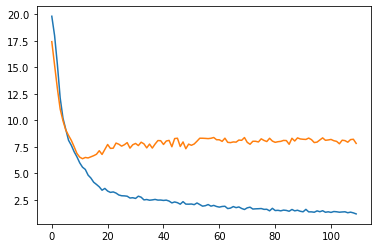

In [10]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
# plt.yscale('log')

1/1 [==============================] - 0s 21ms/step


Text(0, 0.5, 'UTS Prediction')

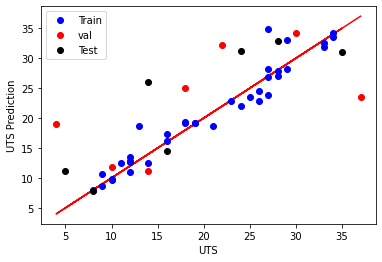

In [11]:
ypredtr =  model.predict(xtrain).squeeze()
ypredts = model.predict(xtest).squeeze()
ypredvl = model.predict(xval).squeeze()

y = [*ytrain,*ytest,*yval]
plt.plot(y,y,'r')
plt.plot(ytrain,ypredtr,'bo',label="Train")
plt.plot(yval,ypredvl,'ro',label="val")
plt.plot(ytest,ypredts,'ko',label = 'Test')
plt.legend()
plt.xlabel(CASE)
plt.ylabel(CASE +' Prediction')

In [12]:
model.evaluate(xval,yval)
model.evaluate(xtest,ytest)
model.evaluate(xtrain,ytrain)

2/2 [==============================] - 0s 2ms/step - loss: 7.5892 - mean_squared_error: 4.6528 - mean_absolute_error: 1.4165 - mean_absolute_percentage_error: 5.0378


[7.589166641235352, 4.652796745300293, 1.4164708852767944, 5.037774562835693]